<a href="https://colab.research.google.com/github/maheshkumar30/Intellipaat-DataScience/blob/main/Netflix_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Recommendation Engine**
**What are recommneder Sytems?**

Recommender systems are algorithms that are designed to suggest items to the user. These systems are used in different domains as e-commerce, Streaming services and social media. It helps us to get the personalized content from the services

#**SVD in a recommendation system**
1. What the system has: Imagine a big table where rows are users and columns are movies, and the table is filled with ratings. but not everyone has rated every movie
2. What SVD Does: SVD looks ar the availabe rating and finds that hidden pattern - Like which user have similar taste and which movies are similar
3. How it will help? - Once SVD learns these patterns, it can guess how much a user mightlike a movie theyif they haven't watched it yet. The system recommends the best ones

In [1]:
#pip install numpy==1.26


In [2]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt


* Header = None --> It treats all rows as data (does not assume that first row is a header)
* names= [custID,Ratings] --> It renames  the columns instead of having indexex
* usecols[0,1] -->

In [3]:
netflix_dataset = pd.read_csv("/content/combined_data_1.txt",header =  None,names = ['Cust_ID','Ratings'],usecols = [0,1])

In [4]:
netflix_dataset.head()

,Cust_ID,Ratings
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


**We will get the count of movies with the help of CustID and rating columns**

In [5]:
movie_count = netflix_dataset.isnull().sum()
movie_count = movie_count['Ratings'] #it will access only ratings
movie_count

4499

**To calculate how many users are there**

In [6]:
total_count = netflix_dataset['Cust_ID'].nunique()
total_count

475257

In [7]:
customer_count = total_count - movie_count
customer_count

470758

**4 lakh 70 thousand 7 hundred and 58**
**I want calculate how many ratings do we have are give by the users**

In [8]:
rating_counts = netflix_dataset['Cust_ID'].count() - movie_count

In [9]:
rating_counts

24053764

**Now,let's find how many users have rated the movies as 1,2,3,4,5 stars**

In [10]:
netflix_dataset.Ratings.value_counts().sort_index()

,count
Ratings,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


In [11]:
stars = netflix_dataset.groupby('Ratings')['Ratings'].agg(['count'])

In [12]:
stars

,count
Ratings,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


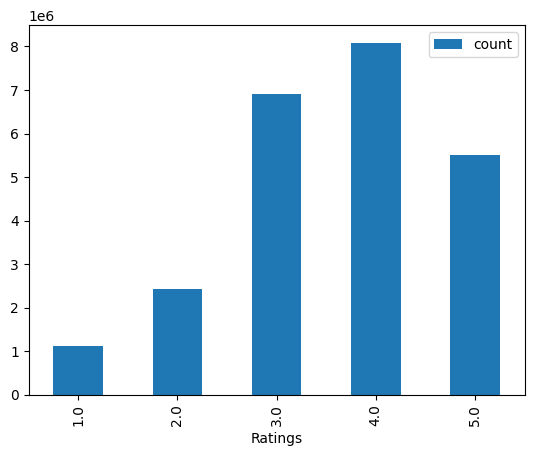

In [13]:
stars.plot(kind = 'bar')
plt.show()

**Let's create clean DataFrame**

In [14]:
movie_id = None
movie_no = [] #Emptu list to store  all movie 1D
for i in netflix_dataset['Cust_ID']:
    if ':' in i:
        movie_id = int(i.replace(':','')) # here we are removing : from movie id
    movie_no.append(movie_id)

In [15]:
len(movie_no)

24058263

**We will create new column in dataset to store movie_id**

In [16]:
netflix_dataset['Movie_ID'] = movie_no
netflix_dataset.head()

,Cust_ID,Ratings,Movie_ID
0,1:,NaN,1
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1


In [17]:
netflix_dataset.isnull().sum()


,0
Cust_ID,0
Ratings,4499
Movie_ID,0


In [18]:
netflix_dataset.dropna(inplace= True)
netflix_dataset.shape

(24053764, 3)

In [19]:
netflix_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24053764 entries, 1 to 24058262
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Cust_ID   object 
 1   Ratings   float64
 2   Movie_ID  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 734.1+ MB


**We will change the dtype of custID from Object to int**

In [20]:
netflix_dataset['Cust_ID'] = netflix_dataset['Cust_ID'].astype(int)
netflix_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24053764 entries, 1 to 24058262
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Cust_ID   int64  
 1   Ratings   float64
 2   Movie_ID  int64  
dtypes: float64(1), int64(2)
memory usage: 734.1 MB


**Now we will do Pre-Filter**
* We will remove all the users who rated less movie
* we will remove all the movies that have been rated less

In [21]:
dataset_movie_summary = netflix_dataset.groupby('Movie_ID')['Ratings'].agg(['count'])
dataset_movie_summary

,count
Movie_ID,
1,547
2,145
3,2012
4,142
5,1140
...,...
4495,614
4496,9519
4497,714


**We will create the benchmark (we will consider a threshold valueof 60 Percentile)

In [22]:
movie_benchmark = round(dataset_movie_summary['count'].quantile(0.6),0)

**This benchmark tells us that movie with ateast 908 ratings are int top60% most rated movie?**

**Goal:Filterout unpopular movies**

In [23]:
drop_movie_list = dataset_movie_summary[dataset_movie_summary['count'] < movie_benchmark] .index
drop_movie_list

Index([   1,    2,    4,    7,    9,   10,   11,   12,   13,   14,
       ...
       4480, 4481, 4486, 4487, 4491, 4494, 4495, 4497, 4498, 4499],
      dtype='int64', name='Movie_ID', length=2699)

**We will remove all the users that are also inactive(who have rated less number of movies)**

In [24]:
dataset_cust_summary = netflix_dataset.groupby('Cust_ID')['Ratings'].agg(['count'])
dataset_cust_summary

,count
Cust_ID,
6,153
7,195
8,21
10,49
25,4
...,...
2649404,12
2649409,10
2649421,3


In [25]:
cust_benchmark = round(dataset_cust_summary['count'].quantile(0.6),0)
cust_benchmark

36.0

**If any user have rated less than 36 movies... We will remove them**

In [26]:
drop_cust_list = dataset_cust_summary[dataset_cust_summary['count']<cust_benchmark].index

~ (tilded) is a negation or Not Operator in Pandas

It inverts the condition:
* isin(drop_movie_list) --> It selects the movie in the list
* ~isin(drop_movie_list) --> It selects the movie that is not present in the list

In [27]:
netflix_dataset[~netflix_dataset['Movie_ID'].isin(drop_movie_list)]
netflix_dataset[~netflix_dataset['Cust_ID'].isin(drop_movie_list)]

,Cust_ID,Ratings,Movie_ID
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


#**Model Building Process**

In [52]:
df_title = pd.read_csv('movie_titles.csv',encoding='latin-1',usecols=[0,1,2],header = None,names= ['Movie_ID','Year','Name'])

In [53]:
df_title.head()

,Movie_ID,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


**Now we will Implement SVD**

In [30]:
pip install scikit-surprise

**To Run SVD we need to downgrade the Numpy to v 1.x**

In [54]:
from surprise import SVD,Reader,Dataset
from surprise.model_selection import cross_validate

* Reader -> It help us to define the format of rating Data(eg:Rating Scale)
* Dataset -> It converts my raw data into format that is suitable for surprise SVD model
* SVD -> It is a matrix factorization algorithm,which gives us latent feature based recommendation
* cross_validation -> it will check how well the model predicts rating on unseen data

In [55]:
reader = Reader()

In [56]:
netflix_dataset.columns

Index(['Cust_ID', 'Ratings', 'Movie_ID'], dtype='object')

In [92]:
data = Dataset.load_from_df(netflix_dataset[['Cust_ID','Movie_ID','Ratings',]][:100000],reader)

In [93]:
data

In [94]:
model = SVD()

In [95]:
cross_validate(model,data,measures = ["RMSE"],cv=5,verbose=2)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0560  1.0501  1.0489  1.0477  1.0505  1.0507  0.0028  
Fit time          2.69    1.62    1.65    1.62    1.81    1.88    0.41    
Test time         0.10    0.10    0.09    0.12    0.44    0.17    0.13    


{'test_rmse': array([1.05597492, 1.05014933, 1.04891414, 1.04773591, 1.05048622]),
 'fit_time': (2.688016176223755,
  1.6172091960906982,
  1.6496756076812744,
  1.6195809841156006,
  1.8065495491027832),
 'test_time': (0.10322403907775879,
  0.09988236427307129,
  0.08861637115478516,
  0.11793971061706543,
  0.43528032302856445)}

In [96]:
netflix_dataset

,Cust_ID,Ratings,Movie_ID
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
...,...,...,...
24058258,2591364,2.0,4499
24058259,1791000,2.0,4499
24058260,512536,5.0,4499
24058261,988963,3.0,4499


In [97]:
# 2591364
user_rating = netflix_dataset[netflix_dataset['Cust_ID'] == 2591364]


In [98]:
user_rating

,Cust_ID,Ratings,Movie_ID
242336,2591364,2.0,46
377930,2591364,2.0,108
495835,2591364,4.0,143
666074,2591364,5.0,175
813455,2591364,4.0,191
...,...,...,...
23617430,2591364,3.0,4418
23802319,2591364,3.0,4432
23809269,2591364,3.0,4439
24018048,2591364,4.0,4488


**This is 2591364 user rated 251 movies**

In [99]:
user_2591364 = df_title.copy()

In [100]:
user_2591364

,Movie_ID,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [101]:
user_2591364['estimated_score'] = user_2591364['Movie_ID'].apply(lambda x: model.predict(2591364,x).est)

In [102]:
user_2591364

,Movie_ID,Year,Name,estimated_score
0,1,2003.0,Dinosaur Planet,3.806679
1,2,2004.0,Isle of Man TT 2004 Review,3.650415
2,3,1997.0,Character,3.704069
3,4,1994.0,Paula Abdul's Get Up & Dance,2.766658
4,5,2004.0,The Rise and Fall of ECW,3.951841
...,...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...,3.530038
17766,17767,2004.0,Fidel Castro: American Experience,3.530038
17767,17768,2000.0,Epoch,3.530038
17768,17769,2003.0,The Company,3.530038


In [106]:
user_2591364.sort_values('estimated_score',ascending=False,inplace=True)

In [107]:
user_2591364

,Movie_ID,Year,Name,estimated_score
12,13,2003.0,Lord of the Rings: The Return of the King: Ext...,4.536437
24,25,1997.0,Inspector Morse 31: Death Is Now My Neighbour,3.980588
4,5,2004.0,The Rise and Fall of ECW,3.951841
27,28,2002.0,Lilo and Stitch,3.857080
17,18,1994.0,Immortal Beloved,3.832939
...,...,...,...,...
25,26,2004.0,Never Die Alone,2.819372
3,4,1994.0,Paula Abdul's Get Up & Dance,2.766658
8,9,1991.0,Class of Nuke 'Em High 2,2.755073
21,22,2000.0,Chump Change,2.320951
